In [6]:
!pip install wandb


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 32.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 1.7 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=ae1fc4a55f93b2713e67b72bee40856f8bad5b4fa330558e6201b9188bac53c6
  Stored in directory: /root/.cache/pip/wheels/b7/0a/67/ada2a22079218c75a88361c0782855cc72aebc4d18d0289d05
Successfully built pathtools


In [1]:
import pandas as pd
import plotly
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import linear_model, metrics, preprocessing
from datetime import datetime, timedelta
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.graph_objs import ColorBar
import re

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1.0 Adult

## 1.1 Read in Data

In [51]:
#alpha_lr = pd.read_csv("/content/drive/MyDrive/Project/WB_Output/wandb_compas_LR_alpha_schedule.csv")
alpha_lr = pd.read_csv("/content/drive/MyDrive/Project/WB_Output/wandb_adult.csv")
alpha_lr = pd.read_csv("/content/drive/MyDrive/Project/WB_Output/wandb_adult_dp.csv")
alpha_lr = alpha_lr.rename( columns = {'alpha_0':'alpha_dp', 
                                         'alpha_1':'alpha_eo', 
                                         'train_dpd':'train_demographic_parity',  
                                         'train_edd':'train_equalized_odds',
                                         'val_dpd':'val_demographic_parity_gap',  
                                         'val_edd':'val_equalized_odds_gap', 
                                         'test_dpd':'test_demographic_parity',  
                                         'test_edd':'test_equalized_odds'})
#alpha_lr = alpha_lr.drop(64,axis=0)

## 1.2 Baseline Model Results

In [52]:
# baseline models
baseline = alpha_lr[(alpha_lr['alpha_dp'] == 0)& (alpha_lr['alpha_eo'] == 0)]
baseline = baseline[['val_accuracy', 'val_demographic_parity_gap','val_equalized_odds_gap']]
baseline = baseline.iloc[[0]]
baseline

,val_accuracy,val_demographic_parity_gap,val_equalized_odds_gap
8,0.590369,0.007384,0.105257


In [55]:
alpha_lr.alpha_dp.unique()

array([150, 100,  50,  40,  30,  20,  10,   1,   0])

# 1.3 Accuracy vs. Demographic Parity | Single Regularizer

In [56]:
# train, alpha, figure
train_cols = [  'val_accuracy' ]#, 'val_demographic_parity_gap',  'val_equalized_odds_gap',
alpha = [0, 1000, 10, 100] #, 200, 300] #, 600] #, 1000, 3000, 6000, 12000]
alpha = [0, 1,10,100] # 3000, 5000] #, 300, 600] #, 600] #, 1000, 3000, 6000, 12000]
alpha = [50, 40, 30, 20, 10,  1,  0]
#alpha = [ 20,  10,   1,   0, 200, 150, 100,  50,  40,  30]
alpha = [150, 100,  50,  40,  30,  20,  10,   1,   0]
fig_train = go.Figure() #make_subplots(rows=2, cols=3, subplot_titles=("validation alpha_dp = 0", "validation alpha_dp = 1", "validation alpha_dp = 10", "validation alpha_dp = 100",  "validation alpha_dp = 1000")) #, "blank"))

# trace colour
trace_colour = {0 :'#636EFA',
                1: '#EF553B',
                10: '#00CC96',
                100 :'#AB63FA',
                1000:'#FFA15A',
                3000:'#19D3F3',
                6000:'#FF6692',
                12000:  '#B6E880',
                600: '#FF97FF',
                300:'#FECB52'}

# single regularizer 
subset = alpha_lr[alpha_lr["alpha_eo"] ==0]

# store X and Y values for each alpha to plot
Y, X = [], []
for a in alpha:
  new_subset = subset[subset["alpha_dp"] == a]

  for col in train_cols:  
    Y.append((new_subset["val_demographic_parity_gap"].values[0]-baseline["val_demographic_parity_gap"].values[0])/baseline["val_demographic_parity_gap"].values[0])
    X.append((new_subset["val_accuracy"].values[0]-baseline["val_accuracy"].values[0])/baseline["val_accuracy"].values[0])



# plot results
fig_train.add_trace(go.Scatter(y=Y, x=X, mode = 'markers+text', text=alpha, marker=dict(
        
        cmax=np.log(600),
        cmin=1,
        color=np.log(alpha),
       
        colorbar=dict(
            title=r'$\alpha_$', 
            ticktext = alpha, 
            tickvals = np.log(alpha)
        ),
        colorscale="Bluered"
    ),))   #trace_colour[a] ,

# update figure and plot
fig_train.update_xaxes(title_text= "Accuracy")
fig_train.update_yaxes(title_text= "Demographic Parity")
fig_train.update_traces(textposition='bottom center') #text=alpha,
fig_train['layout'].update(height=400, width=600)
fig_train.update_layout( 
    legend_title_text=r'$\alpha_ \text{values}$',
    title=r"$\text{Adult Validation } \alpha_{Equalized Odds} = 0$")

  
fig_train.show()

<ipython-input-56-ec7443ab77f0>:41: RuntimeWarning:

divide by zero encountered in log

<ipython-input-56-ec7443ab77f0>:46: RuntimeWarning:

divide by zero encountered in log



# 1.4 Accuracy vs. Equalized Odds | Single Regularizer

In [28]:
# train, alpha, figure
train_cols = [  'val_accuracy', ] #'val_demographic_parity_gap',  'val_equalized_odds_gap',
#alpha = [ 20,  10,   1,   0, 200, 150, 100,  50,  40,  30]
alpha = [50, 40, 30, 20, 10,  1,  0]
fig_train = go.Figure() #make_subplots(rows=2, cols=3, subplot_titles=("validation alpha_dp = 0", "validation alpha_dp = 1", "validation alpha_dp = 10", "validation alpha_dp = 100",  "validation alpha_dp = 1000")) #, "blank"))


#trace colour
trace_colour = {0 :'#636EFA',
                1: '#EF553B',
                10: '#00CC96',
                100 :'#AB63FA',
                1000:'#FFA15A',
                3000:'#19D3F3',
                6000:'#FF6692',
                12000:  '#B6E880',
                600: '#FF97FF',
                300:'#FECB52'}

# single regularizer 
subset = alpha_lr[alpha_lr["alpha_dp"] ==0]

# store X and Y values for each alpha to plot
Y, X = [], []
for a in alpha:
  new_subset = subset[subset["alpha_eo"] == a]

  for col in train_cols:  
    Y.append((new_subset["val_equalized_odds_gap"].values[0]-baseline["val_equalized_odds_gap"].values[0])/baseline["val_equalized_odds_gap"].values[0])
    X.append((new_subset["val_accuracy"].values[0]-baseline["val_accuracy"].values[0])/baseline["val_accuracy"].values[0])

# plot

fig_train.add_trace(go.Scatter(y=Y, x=X, mode = 'markers+text',  text=alpha, marker=dict(
        
        cmax=np.log(200),
        cmin=1,
        color=np.log(alpha),
       
        colorbar=dict(
            title=r'$\alpha_$', 
            ticktext = alpha, 
            tickvals = np.log(alpha)
        ),
        colorscale="Bluered"
    ),))   #trace_colour[a] ,

# update figure and plot
fig_train.update_xaxes(title_text= "Accuracy")
fig_train.update_yaxes(title_text= "Equalized Odds")
fig_train.update_traces(textposition='bottom center') 
fig_train['layout'].update(height=400, width=600)
fig_train.update_layout( 
    legend_title_text=r'$\alpha_ \text{values}$',
    title=r"$\text{Adult Validation } \alpha_{Demographic Parity} = 0$")

  
fig_train.show()

<ipython-input-28-5156a91120fc>:37: RuntimeWarning:

divide by zero encountered in log

<ipython-input-28-5156a91120fc>:42: RuntimeWarning:

divide by zero encountered in log



# 1.5 Demographic Parity vs. Equalized Odds | Single Regularizer

In [29]:
# train, alpha, figure
train_cols = [  'val_accuracy', ] #'val_demographic_parity_gap',  'val_equalized_odds_gap',
alpha = [0, 1,10,100]  #, 600] #, 1000, 3000, 6000, 12000]
alpha = [50, 40, 30, 20, 10,  1,  0]
fig_train = go.Figure() #make_subplots(rows=2, cols=3, subplot_titles=("validation alpha_dp = 0", "validation alpha_dp = 1", "validation alpha_dp = 10", "validation alpha_dp = 100",  "validation alpha_dp = 1000")) #, "blank"))

# trace colour
trace_colour = {0 :'#636EFA',
                1: '#EF553B',
                10: '#00CC96',
                100 :'#AB63FA',
                1000:'#FFA15A',
                3000:'#19D3F3',
                6000:'#FF6692',
                12000:  '#B6E880',
                600: '#FF97FF',
                300:'#FECB52'}

# single regularizer 
subset = alpha_lr[alpha_lr["alpha_dp"] ==0]

# store X and Y values for each alpha to plot
Y, X = [], []
for a in alpha:
  new_subset = subset[subset["alpha_eo"] == a]

  for col in train_cols:  
    Y.append((new_subset["val_equalized_odds_gap"].values[0]-baseline["val_equalized_odds_gap"].values[0])/baseline["val_equalized_odds_gap"].values[0])
    X.append((new_subset["val_demographic_parity_gap"].values[0]-baseline["val_demographic_parity_gap"].values[0])/baseline["val_demographic_parity_gap"].values[0])

# plot
fig_train.add_trace(go.Scatter(y=Y, x=X, mode = 'markers+text',  text=alpha, marker=dict(
        
        cmax=np.log(600),
        cmin=1,
        color=np.log(alpha),
       
        colorbar=dict(
            title=r'$\alpha_$', 
            ticktext = alpha, 
            tickvals = np.log(alpha)
        ),
        colorscale="Bluered"
    ),))   #trace_colour[a] ,

# update figure and plot
fig_train.update_xaxes(title_text= "Demographic Parity Gap")
fig_train.update_yaxes(title_text= "Equalized Odds Gap")
fig_train.update_traces(textposition='bottom center') 
fig_train['layout'].update(height=400, width=600)
fig_train.update_layout( 
    legend_title_text=r'$\alpha_ \text{values}$',
    title=r"$\text{Adult Validation } \alpha_{Demographic Parity} = 0$")

  
fig_train.show()

<ipython-input-29-b054e6370f27>:36: RuntimeWarning:

divide by zero encountered in log

<ipython-input-29-b054e6370f27>:41: RuntimeWarning:

divide by zero encountered in log



## 1.6 Heatmaps | Combined Regularizers

### 1.6.1 Prepare Heatmap

In [43]:

heatmap_df = alpha_lr[['alpha_eo', 'alpha_dp','val_accuracy', 'val_demographic_parity_gap','val_equalized_odds_gap']]
heatmap_df['%dpd'] = heatmap_df.val_demographic_parity_gap.apply(lambda x: (x-baseline.val_demographic_parity_gap)/baseline.val_demographic_parity_gap )
heatmap_df['%eod'] = heatmap_df.val_equalized_odds_gap.apply(lambda x: (x-baseline.val_equalized_odds_gap)/baseline.val_equalized_odds_gap )
heatmap_df['%acc'] = heatmap_df.val_accuracy.apply(lambda x: (x-baseline.val_accuracy)/baseline.val_accuracy )
heatmap_df['acc/dpd'] = heatmap_df['%acc']/heatmap_df['%dpd'].fillna(0)
heatmap_df['acc/eod'] = heatmap_df['%acc']/heatmap_df['%eod'].fillna(0)

<ipython-input-43-5d3b159d1a55>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-43-5d3b159d1a55>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-43-5d3b159d1a55>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-43-5d3b159

### 1.6.2 Heatmap: % Change in Accuracy

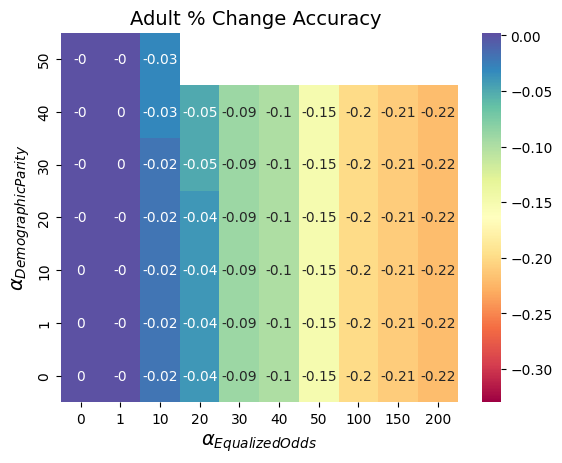

In [49]:
df_dpd_heat_map = heatmap_df.pivot(index='alpha_dp',columns='alpha_eo',values='%acc')
df_dpd_heat_map = df_dpd_heat_map.sort_values(by='alpha_dp',ascending=False).round(2)
sns.heatmap(df_dpd_heat_map,vmax = 0.0025, vmin = -0.33,annot=True,cmap="Spectral")
plt.title("Adult % Change Accuracy ",fontsize=14)
plt.xlabel(r"$\alpha_{Equalized Odds}$",fontsize=14)
plt.ylabel(r"$\alpha_{Demographic Parity}$",fontsize=14)
plt.show()

### 1.6.3 Heatmap: % Change in Equalized Odds

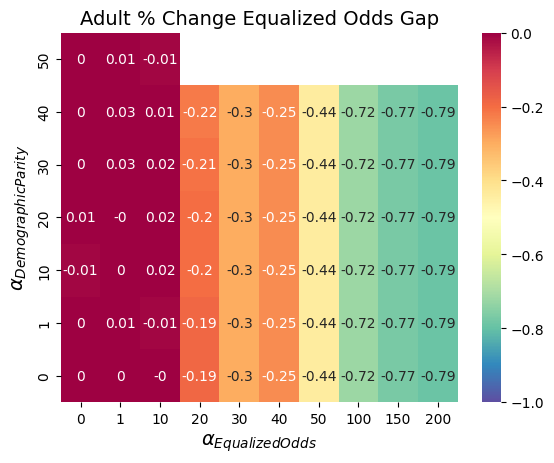

In [48]:
df_eod_heat_map = heatmap_df.pivot(index='alpha_dp',columns='alpha_eo',values='%eod')
df_eod_heat_map = df_eod_heat_map.sort_values(by='alpha_dp',ascending=False).round(2)
sns.heatmap(df_eod_heat_map,vmax = 0,vmin =-1, annot=True,cmap="Spectral_r")
plt.title("Adult % Change Equalized Odds Gap",fontsize=14)
plt.xlabel(r"$\alpha_{Equalized Odds}$",fontsize=14)
plt.ylabel(r"$\alpha_{Demographic Parity}$",fontsize=14)
plt.show()

### 1.6.4 Heatmap: % Change in Demographic Parity

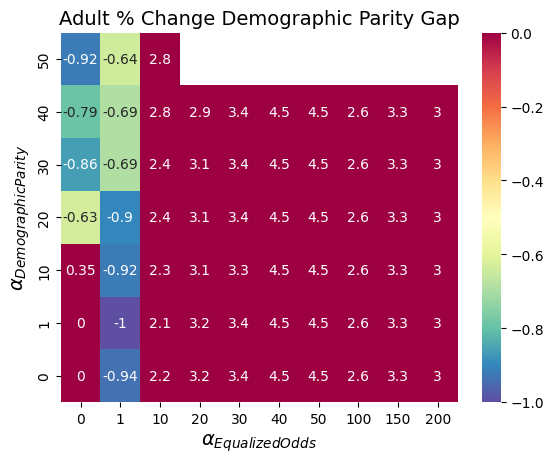

In [47]:
df_eod_heat_map = heatmap_df.pivot(index='alpha_dp',columns='alpha_eo',values='%dpd')
df_eod_heat_map = df_eod_heat_map.sort_values(by='alpha_dp',ascending=False).round(2)
sns.heatmap(df_eod_heat_map,vmax = 0,vmin =-1, annot=True,cmap="Spectral_r")
plt.title("Adult % Change Demographic Parity Gap",fontsize=14)
plt.xlabel(r"$\alpha_{Equalized Odds}$",fontsize=14)
plt.ylabel(r"$\alpha_{Demographic Parity}$",fontsize=14)
plt.show()